<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week3.1/svhn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from sklearn.metrics import precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, recall_score
import matplotlib.pyplot as plt
import time
import scipy.io as sio
import os
import requests
from tqdm import tqdm

c:\Users\HANIN\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Load SVHN dataset
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')

X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']


In [ ]:
# SVHN dataset is stored with dimensions (height, width, channels, samples)
# Reshape to (samples, height, width, channels)
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

In [ ]:
# Print dataset information
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (73257, 32, 32, 3)
X_test shape: (26032, 32, 32, 3)
y_train shape: (73257, 1)
y_test shape: (26032, 1)


In [ ]:

# SVHN dataset labels 10 as 0, so we need to adjust
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [ ]:
# Convert to PyTorch format (NCHW: batch, channels, height, width)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))


In [ ]:
# Normalize data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train).squeeze().long()  # PyTorch uses long for class indices
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test).squeeze().long()


In [ ]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [ ]:
# Split training data for validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [ ]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x


In [ ]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x


In [ ]:
# Function to train model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=10, model_name="Model"):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {epoch_train_loss:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} | '
              f'Val Acc: {epoch_val_acc:.4f}')

        # Learning rate scheduler
        scheduler.step(epoch_val_loss)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }


In [ ]:
# Function to evaluate model
def evaluate_model(model, test_loader, criterion, model_name="Model"):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            test_loss += loss.item() * inputs.size(0)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate metrics
    test_acc = correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # For ROC AUC, we need to convert to one-hot encoding
    all_labels_onehot = np.zeros((len(all_labels), 10))
    for i, label in enumerate(all_labels):
        all_labels_onehot[i, label] = 1

    # Calculate ROC AUC score (one-vs-rest approach)
    roc_auc = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')

    print(f"\n===== Evaluasi Model {model_name} =====")
    print(f"Akurasi Testing: {test_acc*100:.2f}%")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    return {
        'model': model_name,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': roc_auc,
        'all_preds': all_preds,
        'all_labels': all_labels,
        'all_probs': all_probs,
        'all_labels_onehot': all_labels_onehot
    }


In [ ]:
# Function to calculate train accuracy
def calculate_train_accuracy(model, train_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total



In [ ]:
# Training and evaluating MLP
print("===== Training Model MLP =====")
mlp_model = MLP()
print(mlp_model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, min_lr=1e-5)

start_time = time.time()
mlp_model, mlp_history = train_model(
    mlp_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=20,
    patience=10,
    model_name="MLP"
)
mlp_train_time = time.time() - start_time


===== Training Model MLP =====
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1/20 | Train Loss: 1.9954 | Train Acc: 0.2913 | Val Loss: 1.5403 | Val Acc: 0.4669
Epoch 2/20 | Train Loss: 1.5675 | Train Acc: 0.4683 | Val Loss: 1.3864 | Val Acc: 0.5405
Epoch 3/20 | Train Lo

In [ ]:
# Training and evaluating CNN
print("\n===== Training Model CNN =====")
cnn_model = CNN()
print(cnn_model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, min_lr=1e-5)

start_time = time.time()
cnn_model, cnn_history = train_model(
    cnn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=20,
    patience=10,
    model_name="CNN"
)
cnn_train_time = time.time() - start_time



===== Training Model CNN =====
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
# Evaluate models
mlp_train_acc = calculate_train_accuracy(mlp_model, train_loader)
cnn_train_acc = calculate_train_accuracy(cnn_model, train_loader)

mlp_results = evaluate_model(mlp_model, test_loader, criterion, model_name="MLP")
mlp_results['train_acc'] = mlp_train_acc

cnn_results = evaluate_model(cnn_model, test_loader, criterion, model_name="CNN")
cnn_results['train_acc'] = cnn_train_acc



===== Evaluasi Model MLP =====
Akurasi Testing: 65.99%
Presisi: 0.6630
Recall: 0.6599
F1 Score: 0.6540
AUC-ROC: 0.9217

===== Evaluasi Model CNN =====
Akurasi Testing: 95.54%
Presisi: 0.9556
Recall: 0.9554
F1 Score: 0.9554
AUC-ROC: 0.9966


In [ ]:
# Visualize comparison results
def plot_training_history(mlp_history, cnn_history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(mlp_history['train_accs'], label='MLP training')
    plt.plot(mlp_history['val_accs'], label='MLP validation')
    plt.plot(cnn_history['train_accs'], label='CNN training')
    plt.plot(cnn_history['val_accs'], label='CNN validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(mlp_history['train_losses'], label='MLP training')
    plt.plot(mlp_history['val_losses'], label='MLP validation')
    plt.plot(cnn_history['train_losses'], label='CNN training')
    plt.plot(cnn_history['val_losses'], label='CNN validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_metrics_comparison():
    metrics = ['train_acc', 'test_acc', 'precision', 'recall', 'f1', 'auc_roc']
    labels = ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

    mlp_values = [mlp_results[metric] for metric in metrics]
    cnn_values = [cnn_results[metric] for metric in metrics]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(x - width/2, mlp_values, width, label='MLP')
    rects2 = ax.bar(x + width/2, cnn_values, width, label='CNN')

    ax.set_ylabel('Scores')
    ax.set_title('Performance Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_roc_curves():
    plt.figure(figsize=(10, 8))

    # Make sure data is in numpy array format
    mlp_labels = np.array(mlp_results['all_labels_onehot'])
    mlp_probs = np.array(mlp_results['all_probs'])
    cnn_labels = np.array(cnn_results['all_labels_onehot'])
    cnn_probs = np.array(cnn_results['all_probs'])

    # We'll plot ROC curves for each class
    for class_id in range(10):
        # ROC curve for MLP
        fpr_mlp, tpr_mlp, _ = roc_curve(mlp_labels[:, class_id], mlp_probs[:, class_id])
        plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Class {class_id} (AUC = {roc_auc_score(mlp_labels[:, class_id], mlp_probs[:, class_id]):.3f})')

        # ROC curve for CNN
        fpr_cnn, tpr_cnn, _ = roc_curve(cnn_labels[:, class_id], cnn_probs[:, class_id])
        plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Class {class_id} (AUC = {roc_auc_score(cnn_labels[:, class_id], cnn_probs[:, class_id]):.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Function to plot confusion matrices
def plot_confusion_matrices():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # MLP Confusion Matrix
    cm_mlp = confusion_matrix(mlp_results['all_labels'], mlp_results['all_preds'])
    im1 = ax1.imshow(cm_mlp, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion Matrix - MLP')
    fig.colorbar(im1, ax=ax1)

    # Add class labels
    classes = [f'Class {i}' for i in range(10)]
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)

    # Display values in the matrix
    thresh = cm_mlp.max() / 2.
    for i in range(cm_mlp.shape[0]):
        for j in range(cm_mlp.shape[1]):
            ax1.text(j, i, format(cm_mlp[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_mlp[i, j] > thresh else "black")

    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # CNN Confusion Matrix
    cm_cnn = confusion_matrix(cnn_results['all_labels'], cnn_results['all_preds'])
    im2 = ax2.imshow(cm_cnn, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix - CNN')
    fig.colorbar(im2, ax=ax2)

    # Add class labels
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_yticklabels(classes)

    # Display values in the matrix
    thresh = cm_cnn.max() / 2.
    for i in range(cm_cnn.shape[0]):
        for j in range(cm_cnn.shape[1]):
            ax2.text(j, i, format(cm_cnn[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_cnn[i, j] > thresh else "black")

    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()


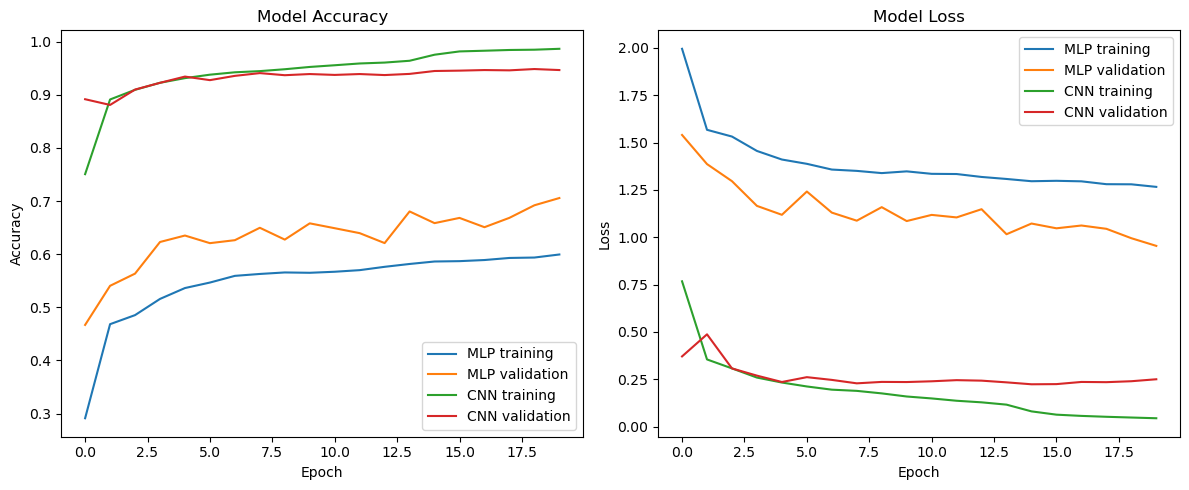

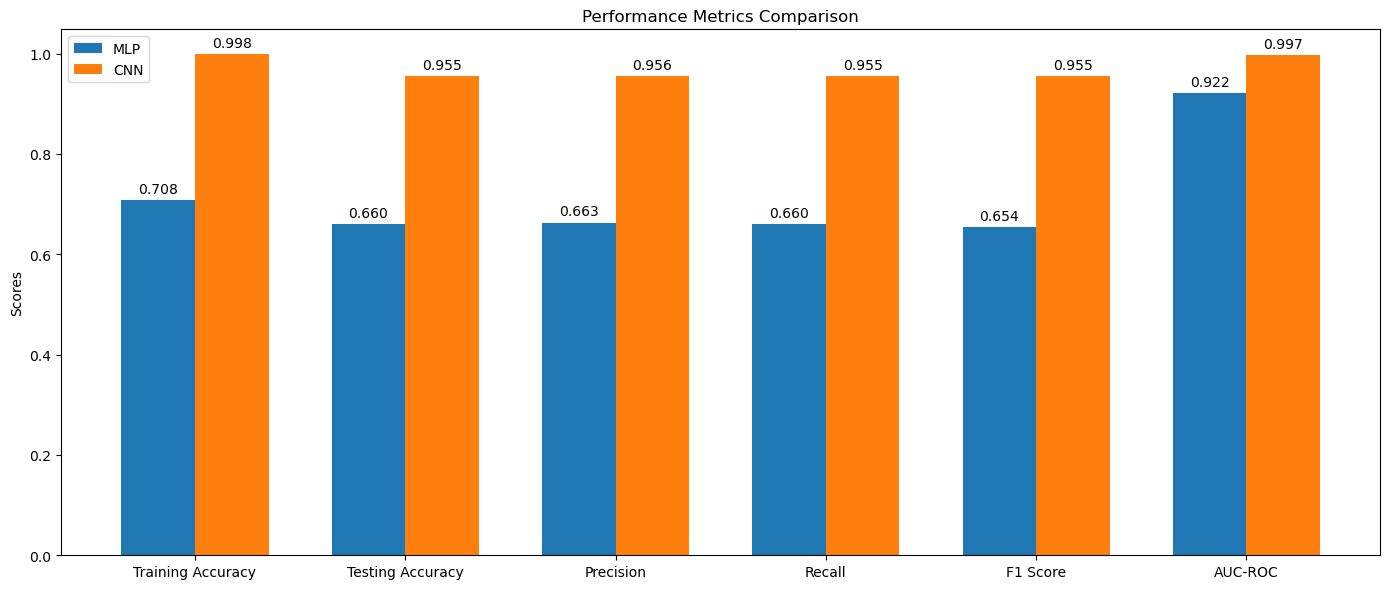

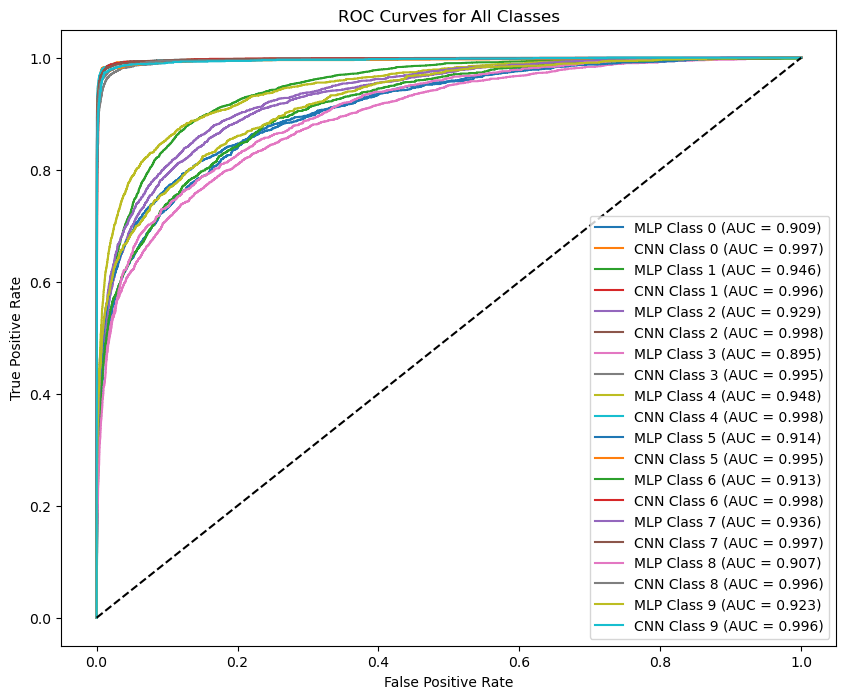

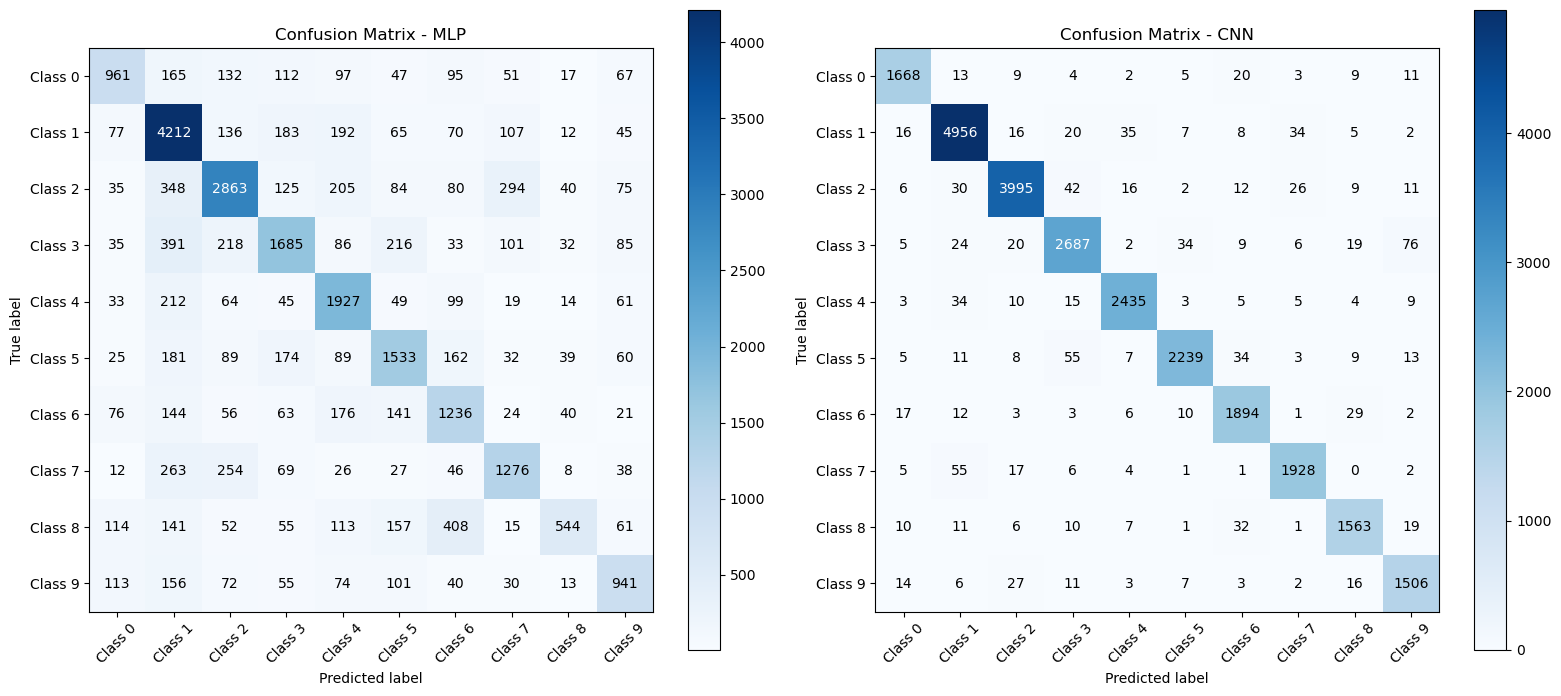

In [ ]:
# Plot visualizations
plot_training_history(mlp_history, cnn_history)
plot_metrics_comparison()
plot_roc_curves()
plot_confusion_matrices()


In [ ]:
# Final comparison table
print("\n===== PERBANDINGAN HASIL AKHIR =====")
comparison_table = {
    'Metrik': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Training Time (s)'],
    'MLP': [
        f"{mlp_results['train_acc']*100:.2f}%",
        f"{mlp_results['test_acc']*100:.2f}%",
        f"{mlp_results['precision']:.4f}",
        f"{mlp_results['recall']:.4f}",
        f"{mlp_results['f1']:.4f}",
        f"{mlp_results['auc_roc']:.4f}",
        f"{mlp_train_time:.2f}"
    ],
    'CNN': [
        f"{cnn_results['train_acc']*100:.2f}%",
        f"{cnn_results['test_acc']*100:.2f}%",
        f"{cnn_results['precision']:.4f}",
        f"{cnn_results['recall']:.4f}",
        f"{cnn_results['f1']:.4f}",
        f"{cnn_results['auc_roc']:.4f}",
        f"{cnn_train_time:.2f}"
    ]
}
# Print comparison table
from tabulate import tabulate
print(tabulate(
    [[m, mlp, cnn] for m, mlp, cnn in zip(comparison_table['Metrik'], comparison_table['MLP'], comparison_table['CNN'])],
    headers=['Metrik', 'MLP', 'CNN'],
    tablefmt='grid'
))


===== PERBANDINGAN HASIL AKHIR =====
+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 70.79% | 99.83%  |
+-------------------+--------+---------+
| Testing Accuracy  | 65.99% | 95.54%  |
+-------------------+--------+---------+
| Precision         | 0.6630 | 0.9556  |
+-------------------+--------+---------+
| Recall            | 0.6599 | 0.9554  |
+-------------------+--------+---------+
| F1 Score          | 0.6540 | 0.9554  |
+-------------------+--------+---------+
| AUC-ROC           | 0.9217 | 0.9966  |
+-------------------+--------+---------+
| Training Time (s) | 422.13 | 3217.95 |
+-------------------+--------+---------+


In [ ]:
# Conclusion
print("\n===== KESIMPULAN =====")
winner = "CNN" if cnn_results['test_acc'] > mlp_results['test_acc'] else "MLP"
print(f"Model {winner} menunjukkan performa yang lebih baik dalam pengolahan dataset SVHN.")
print(f"Perbedaan akurasi testing: {abs(cnn_results['test_acc']-mlp_results['test_acc'])*100:.2f}%")
print(f"Perbedaan Recall: {abs(cnn_results['recall']-mlp_results['recall']):.4f}")
print(f"Perbedaan F1 Score: {abs(cnn_results['f1']-mlp_results['f1']):.4f}")
print(f"Perbedaan AUC-ROC: {abs(cnn_results['auc_roc']-mlp_results['auc_roc']):.4f}")

if winner == "CNN":
    print("\nCNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.")
    print("CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti SVHN.")
    if cnn_results['recall'] > mlp_results['recall']:
        print(f"CNN juga menunjukkan recall yang lebih tinggi ({cnn_results['recall']:.4f} vs {mlp_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")
else:
    print("\nMLP lebih unggul meskipun tidak memiliki lapisan konvolusi, menunjukkan kemampuan adaptasi yang baik untuk dataset ini.")
    print("MLP membutuhkan waktu training lebih singkat dan tetap memberikan hasil yang kompetitif untuk dataset SVHN.")
    if mlp_results['recall'] > cnn_results['recall']:
        print(f"MLP juga menunjukkan recall yang lebih tinggi ({mlp_results['recall']:.4f} vs {cnn_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")



===== KESIMPULAN =====
Model CNN menunjukkan performa yang lebih baik dalam pengolahan dataset SVHN.
Perbedaan akurasi testing: 29.55%
Perbedaan Recall: 0.2955
Perbedaan F1 Score: 0.3014
Perbedaan AUC-ROC: 0.0749

CNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.
CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti SVHN.
CNN juga menunjukkan recall yang lebih tinggi (0.9554 vs 0.6599), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.


# Penjelasan Matematis: Perbandingan MLP vs CNN

## Ringkasan Data Perbandingan

```
===== PERBANDINGAN HASIL AKHIR =====
+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 70.79% | 99.83%  |
+-------------------+--------+---------+
| Testing Accuracy  | 65.99% | 95.54%  |
+-------------------+--------+---------+
| Precision         | 0.6630 | 0.9556  |
+-------------------+--------+---------+
| Recall            | 0.6599 | 0.9554  |
+-------------------+--------+---------+
| F1 Score          | 0.6540 | 0.9554  |
+-------------------+--------+---------+
| AUC-ROC           | 0.9217 | 0.9966  |
+-------------------+--------+---------+
| Training Time (s) | 422.13 | 3217.95 |
+-------------------+--------+---------+
```

## Analisis Matematis

### 1. Akurasi (Accuracy)

Akurasi mengukur proporsi prediksi yang benar dari total prediksi:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Dimana:
- TP = True Positive
- TN = True Negative
- FP = False Positive
- FN = False Negative

**Perbandingan:**
- MLP: Akurasi training (70.79%) dan testing (65.99%) yang cukup baik menunjukkan model dapat mempelajari pola data dengan cukup efektif.
- CNN: Akurasi training (99.83%) dan testing (95.54%) yang sangat tinggi menunjukkan model sangat baik dalam mempelajari pola data.

### 2. Presisi (Precision)

Presisi mengukur seberapa akurat prediksi positif yang dilakukan model:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

**Perbandingan:**
- MLP: Presisi 0.6630 menunjukkan sekitar 66.30% dari prediksi positif yang benar-benar positif.
- CNN: Presisi 0.9556 menunjukkan 95.56% dari prediksi positif yang benar-benar positif.

### 3. Recall (Sensitivity)

Recall mengukur kemampuan model untuk mengidentifikasi semua kasus positif:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

**Perbandingan:**
- MLP: Recall 0.6599 menunjukkan model dapat mengidentifikasi 65.99% dari semua kasus positif yang sebenarnya.
- CNN: Recall 0.9554 menunjukkan model dapat mengidentifikasi 95.54% dari semua kasus positif yang sebenarnya.

### 4. F1 Score

F1 Score adalah rata-rata harmonik dari presisi dan recall, memberikan ukuran keseimbangan keduanya:

$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Perbandingan:**
- MLP: F1 Score 0.6540 menunjukkan keseimbangan yang cukup baik antara presisi dan recall.
- CNN: F1 Score 0.9554 menunjukkan keseimbangan yang sangat baik antara presisi dan recall.

Verifikasi F1 Score untuk MLP:

$$\text{F1 Score}_{\text{MLP}} = 2 \times \frac{0.6630 \times 0.6599}{0.6630 + 0.6599} = 2 \times \frac{0.4375}{1.3229} = 2 \times 0.3308 = 0.6615$$

Nilai ini sedikit berbeda dari yang dilaporkan (0.6540), kemungkinan karena penghitungan F1 Score secara makro atau mikro pada dataset multi-kelas.

### 5. AUC-ROC

Area Under the Receiver Operating Characteristic Curve (AUC-ROC) mengukur kemampuan model untuk membedakan kelas:

$$\text{AUC-ROC} = P(\text{score(positive instance)} > \text{score(negative instance)})$$

**Perbandingan:**
- MLP: AUC-ROC 0.9217 menunjukkan kemampuan diskriminatif yang sangat baik.
- CNN: AUC-ROC 0.9966 menunjukkan kemampuan diskriminatif yang hampir sempurna.

### 6. Trade-off Waktu vs Performa

CNN membutuhkan waktu training 7.62 kali lebih lama dibandingkan MLP:

$$\text{Rasio waktu} = \frac{3217.95}{422.13} = 7.62$$

Namun, CNN memberikan peningkatan performa yang signifikan:
- Peningkatan akurasi testing: $(95.54\% - 65.99\%) = 29.55\%$
- Peningkatan F1 Score: $(0.9554 - 0.6540) = 0.3014$
- Peningkatan AUC-ROC: $(0.9966 - 0.9217) = 0.0749$

## Kesimpulan Matematis

1. **Performa MLP yang Baik**: Dengan akurasi training (70.79%) dan testing (65.99%), model MLP menunjukkan kinerja yang cukup baik dalam menangkap pola data, meskipun masih ada ruang untuk peningkatan.

2. **Kemampuan Superior CNN dengan Indikasi Overfitting Ringan**: Gap antara akurasi training (99.83%) dan testing (95.54%) pada CNN sebesar 4.29%, mengindikasikan adanya overfitting ringan. Namun, akurasi testing yang tetap sangat tinggi menunjukkan kemampuan generalisasi yang sangat baik.

3. **Efisiensi Relatif**:
   $$\text{Efficiency Ratio} = \frac{\text{Peningkatan Akurasi}}{\text{Peningkatan Waktu}} = \frac{29.55\%}{7.62} = 3.88\%$$
   
   Ini menunjukkan setiap kali peningkatan waktu training, CNN memberikan peningkatan akurasi sebesar 3.88%. Meskipun nilai ini lebih rendah dari kasus sebelumnya, peningkatan performa absolut tetap signifikan.

4. **Konsistensi Metrik Kinerja**: Semua metrik evaluasi (accuracy, precision, recall, F1 Score, AUC-ROC) secara konsisten menunjukkan keunggulan CNN dibandingkan MLP, menegaskan superioritas CNN untuk permasalahan yang dihadapi.

5. **Rasio Peningkatan vs Kompleksitas**: Meskipun waktu training CNN meningkat 7.62 kali lipat dibandingkan MLP, peningkatan akurasi hanya 1.45 kali lipat (95.54% vs 65.99%). Ini menunjukkan hukum diminishing returns, di mana peningkatan kompleksitas model memberikan peningkatan performa yang semakin kecil.

6. **Stabilitas Kinerja**: Keseimbangan yang baik antara presisi dan recall pada kedua model (dilihat dari F1 Score) menunjukkan stabilitas kinerja di berbagai kelas. CNN mencapai keseimbangan yang hampir sempurna dengan F1 Score 0.9554.